In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from copy import deepcopy


Data used in this notebook can be found [here](https://drive.google.com/file/d/1Kjd2UMhcNbRB2YfVvXM6i3rJ4kvS0-WK/view?usp=share_link)

In [4]:
# Load Data
output_path = './'

claims_df = pd.read_csv(os.path.join(output_path, 'claims_from_85901_to_86301.csv'))
proofs_df = pd.read_csv(os.path.join(output_path, 'proofs_from_85901_to_86301.csv'))
txs_by_block_df = pd.read_csv(os.path.join(output_path, 'txs_by_block_from_85901_to_86301.csv'))


# Proof / Claim Distribution

In this first seccion we calculate the metrics related to the distribution of POKT in Claims and Proofs.

In [5]:
# Get successful and failed claims
failed_claims_df = claims_df.loc[claims_df['result_code'] != 0].copy()
successfull_claims_df = claims_df.loc[claims_df['result_code'] == 0].copy()

In [6]:
print('Percentage of failed claims: %0.2f%%' % ((len(failed_claims_df)/(len(successfull_claims_df)+len(failed_claims_df))) * 100.))

Percentage of failed claims: 0.43%


In [7]:
# Get total_pokt up to different coverages
all_cases = len(claims_df) # Total number of claims
emp_cdf = list() # Here we will store the empirical CDF
support = np.linspace(0,50,100) # Granularity in POKT
for limit_pokt in support:
    # Get all proofs that meet this criteria (POKT lower than limit_pokt)
    cases_here = len(claims_df.loc[claims_df['total_pokt'] <= limit_pokt])
    # Add the fraction of the total proofs that met the criteria
    emp_cdf.append(cases_here/all_cases)
# Convert to numpy
emp_cdf = np.array(emp_cdf)

In [8]:
table_values = [.25, .5, .75, .90, .95]  # Percentiles we want to calculate
colores = ['grey', 'green', 'yellow', 'orange', 'red'] # For later plot
# Calculate the limits for each percentile
limit_rows = list()
for value in table_values:
    arg_here = np.argmin((emp_cdf-value)**2) # Find closest point in the empirical CDF
    limit_rows.append([value*100., support[arg_here]]) # Convert to percentage and save

table_df = pd.DataFrame(limit_rows, columns=['Percentage', 'Limit']) # Create result dataframe
table_df # Display

,Percentage,Limit
0,25.0,1.010101
1,50.0,3.030303
2,75.0,5.555556
3,90.0,15.656566
4,95.0,18.181818


### Plots

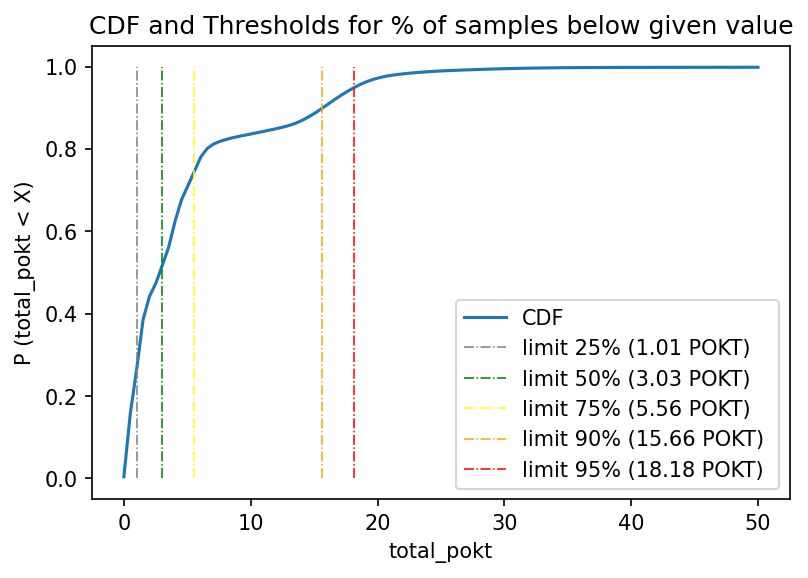

In [9]:
# Plot the CDF

plt.figure(dpi=150)
plt.title('CDF and Thresholds for % of samples below given value')
lengend_names = list()
plt.plot(support, emp_cdf)
lengend_names.append('CDF')

for row, c in zip(limit_rows, colores):
    plt.vlines(row[1], ymin=0, ymax = 1.0, linestyles='-.', colors=c, lw=0.75)
    lengend_names.append('limit %d%% (%0.2f POKT) '%(row[0], row[1]))


plt.ylabel('P (total_pokt < X)')
plt.xlabel('total_pokt')
plt.legend(lengend_names)
plt.show()

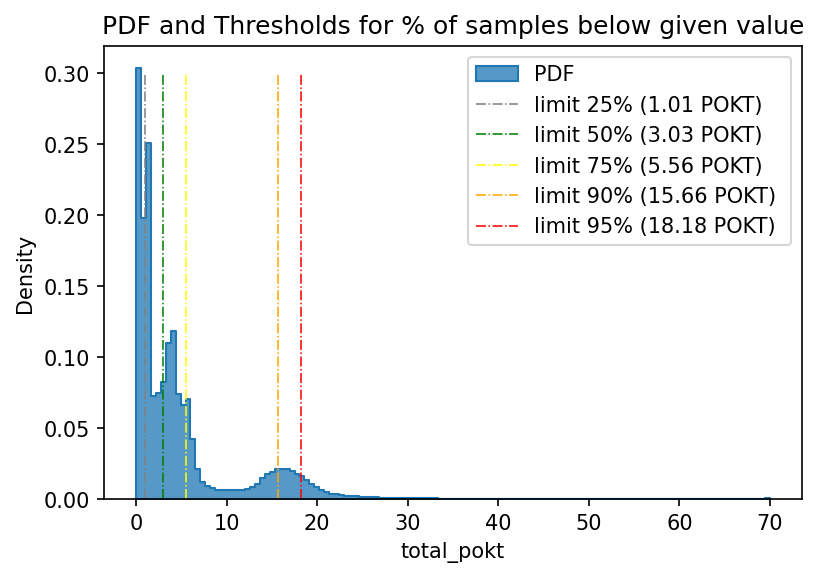

In [12]:
# Plot the PDF 

plt.figure(dpi = 150)
lengend_names = list()
plt.title('PDF and Thresholds for % of samples below given value')

sns.histplot(data=claims_df, x="total_pokt", bins = 128, stat="density", element="step")
lengend_names.append('PDF')
for row, c in zip(limit_rows, colores):
    plt.vlines(row[1], ymin=0, ymax = 0.3, linestyles='-.', colors=c, lw=0.75)
    lengend_names.append('limit %d%% (%0.2f POKT) '%(row[0], row[1]))
plt.legend(lengend_names)
plt.show()

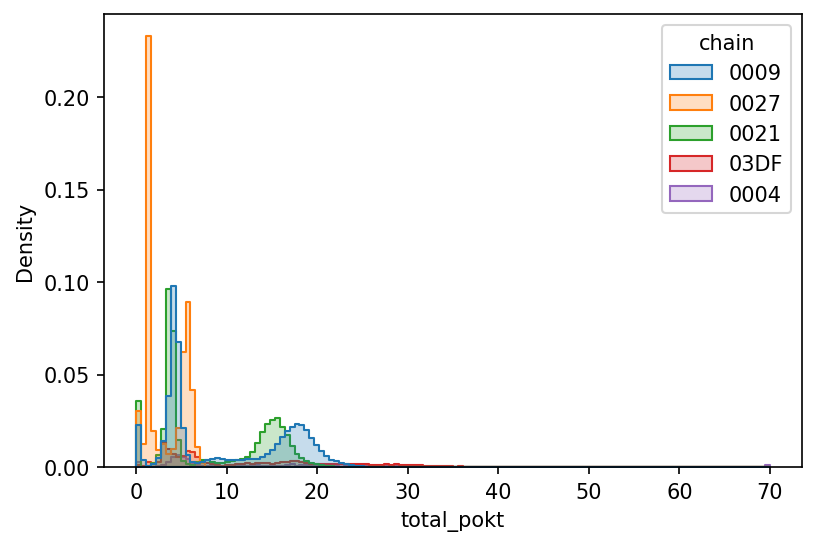

In [11]:
# Plot a descriptive distribution of the proof for the largest blockchains

data_use = claims_df.loc[claims_df['chain'].isin(['0021', '0009', '0027', '03DF', '0004'])]

plt.figure(dpi = 150)
sns.histplot(data=data_use, x="total_pokt", hue="chain", bins = 128, stat="density", element="step")
plt.show()

# Block Size Composition in Bytes

Here we analyze the impact of proofs in a block. 
Block size and proof size is obtained from [here](https://docs.google.com/document/d/1QcsPfhj636zBazw2jAay8H6gdBKXcIMmohY0o321hhQ/edit#).
The data extracted from this document is:
1. A proof of $1\times 10^6 $ relays weights `1884 bytes`
2. The largest possible claims weights `401 bytes`
3. The block contains:
    1. Header `653 bytes`
    1. Amino Overhead `11 bytes`
    1. Validator size: `num_validators * 223 bytes`
    1. Evidence size: `NumOfEvidence * 484 bytes` (we dont know the `NumOfEvidence`, we will use 1000)


Also @Olshansk noted that the proof size grows following $\mathcal{O}(\log{}n)$, where $n$ is the number of relays in a claim.

Finally we know that the raw block size is `800 KB` lower than reported size (json structures if I recall correctly).


In [13]:
proof_1M_r = 1884
largest_claim = 401
num_proof = 1000 # Made-up number, replace with real value if we find it...
proof_size = 484
num_validators = 1000
validator_size = 223
header_size = 653
amino_overhead = 11

# Given the previous iformation we can create the following function
def relays_to_proof_size(relays, proof_1M_r = 1884):
    '''
    Numeber of relays to proof size approximation

    We expect the size of the proof to scale in O(long(r)) whith respect to the
    number of relays (r). 
    If we know the size of the proof for 1e6 relays (proof_1M_r), we can scale 
    down/up from there. 
    '''
    
    return (np.log(relays)/np.log(1e6))*proof_1M_r

In [15]:
# Get estimation of block size and components for each block

# Convert the mean number of proof relays to bytes and multiply by totoal number of proof in each block
txs_by_block_df['mean_proof_size'] = relays_to_proof_size(txs_by_block_df['mean_proof_relays'])*txs_by_block_df['num_proofs']
# Get the worst-case size used by claims by multipliying the observed claims by the largest proof size, for each block
txs_by_block_df['worst_case_claim_size'] = largest_claim*txs_by_block_df['num_claim']
# Get the raw block size
txs_by_block_df['block_size'] = txs_by_block_df['block_size'] - (800 * 1024) # Raw block size, this is the one that matters
# Get the size that was used for txs only
txs_by_block_df['txs_block_size'] = txs_by_block_df['block_size'] - header_size - amino_overhead - (num_validators * validator_size) - (proof_size * proof_size)


txs_by_block_df # display

,Unnamed: 0,height,total_proof,num_proofs,mean_proof_relays,block_size,num_send,num_claim,num_stake_validator,num_unjail_validator,num_dao_tranfer,num_begin_unstake_validator,mean_proof_size,worst_case_claim_size,txs_block_size
0,0,85901,10384.293090,1317,10384.293090,2905878,111,1355,0.0,0.0,0.0,0.0,1.660924e+06,543355,2447958
1,1,85902,10772.454001,1337,10772.454001,2947693,149,1333,0.0,1.0,0.0,0.0,1.692838e+06,534533,2489773
2,2,85903,9957.298165,1308,9957.298165,2893085,205,1327,0.0,2.0,0.0,0.0,1.642085e+06,532127,2435165
3,3,85904,10390.594052,1345,10390.594052,2988964,143,1372,0.0,2.0,0.0,0.0,1.696348e+06,550172,2531044
4,4,85905,10925.201945,1337,10925.201945,2948746,138,1313,0.0,0.0,0.0,0.0,1.695405e+06,526513,2490826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,86296,9803.145617,1346,9803.145617,3016644,208,1393,0.0,0.0,0.0,0.0,1.686927e+06,558593,2558724
396,396,86297,9202.846097,1345,9202.846097,2975485,271,1300,0.0,0.0,0.0,0.0,1.674083e+06,521300,2517565
397,397,86298,9708.819196,1344,9708.819196,2966023,255,1282,0.0,0.0,0.0,0.0,1.682648e+06,514082,2508103
398,398,86299,9672.451347,1336,9672.451347,2986852,282,1351,0.0,0.0,0.0,0.0,1.671949e+06,541751,2528932


In [53]:
avg_txs_size = txs_by_block_df['txs_block_size'].mean()
avg_proof_size = txs_by_block_df['mean_proof_size'].mean()
avg_claim_size = txs_by_block_df['worst_case_claim_size'].mean()


avg_proof_consumption = (avg_proof_size/avg_txs_size)*100.
avg_claim_consumption = (avg_claim_size/avg_txs_size)*100.

print('The block TXs portion is composed of:\n\tProofs : %0.2f %%\n\tClaims : %0.2f %%'%(avg_proof_consumption, avg_claim_consumption))


The block TXs portion is composed of:
	Proofs : 67.06 %
	Claims : 21.64 %


### Plots

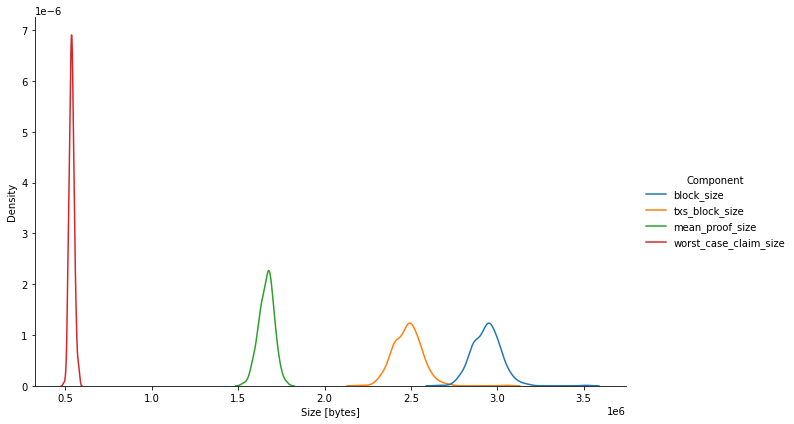

In [59]:
plot_df = pd.melt(txs_by_block_df, id_vars=['height'], 
            value_vars=["block_size", "txs_block_size", "mean_proof_size", 'worst_case_claim_size'])
plot_df['Size [bytes]'] = plot_df['value']
plot_df['Component'] = plot_df['variable']
sns.displot(data=plot_df, x="Size [bytes]", hue="Component", kind="kde", height=6, aspect=1.5)


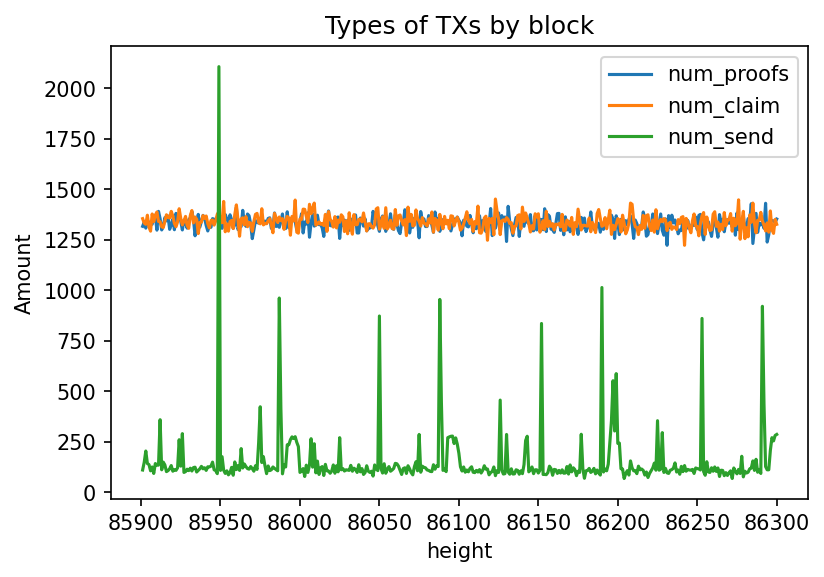

In [19]:
# Show number of txs types by block
plt.figure(dpi=150)
ax = plt.gca()

txs_by_block_df.plot(x='height', y='num_proofs', ax=ax)
txs_by_block_df.plot(x='height', y='num_claim', ax=ax)
txs_by_block_df.plot(x='height', y='num_send', ax=ax)
plt.ylabel('Amount')
plt.title('Types of TXs by block')
plt.show()


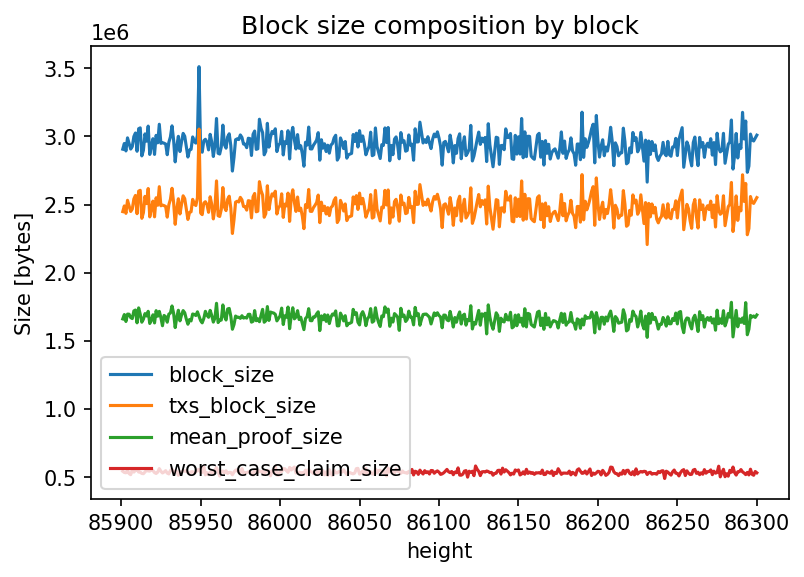

In [20]:
plt.figure(dpi=150)
ax = plt.gca()

txs_by_block_df.plot(x='height', y='block_size', ax=ax)
txs_by_block_df.plot(x='height', y='txs_block_size', ax=ax)

txs_by_block_df.plot(x='height', y='mean_proof_size', ax=ax)
txs_by_block_df.plot(x='height', y='worst_case_claim_size', ax=ax)

plt.ylabel('Size [bytes]')
plt.title('Block size composition by block')
plt.show()

